In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [2]:
#Auxiliar Functions

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])


def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [4]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

In [5]:
#paths para os datasets
pathTrain = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'


In [6]:
BATCH_SIZE = 64

In [7]:
#Ver as classes
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [9]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)
#print(dataset)
# note: this only works if dataset is not repeating
train_Data_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", train_Data_length)  

(32, 32, 3) (43,)
Total images in dataset:  39209


In [10]:
train_Dataset = dataset
train_Dataset = train_Dataset.cache()
train_Dataset = train_Dataset.shuffle(buffer_size = train_Data_length)
train_Dataset = train_Dataset.batch(batch_size=BATCH_SIZE)
train_Dataset = train_Dataset.prefetch(buffer_size = AUTOTUNE)
train_Dataset = train_Dataset.repeat()

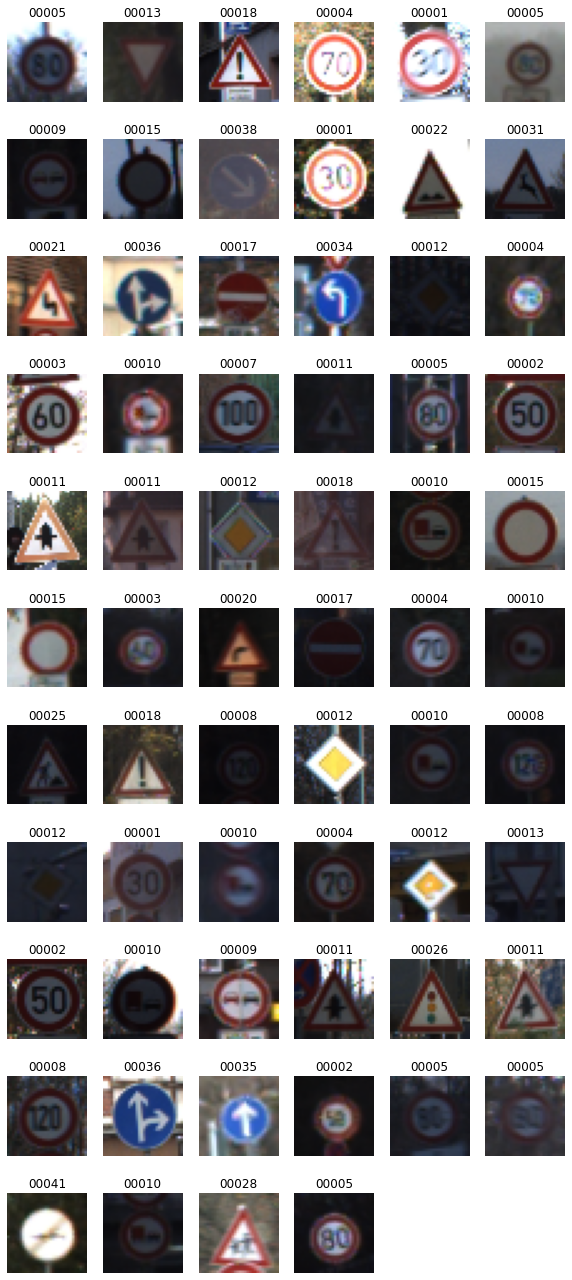

In [11]:
image_batch, label_batch = next(iter(train_Dataset))        
show_batch(image_batch, label_batch.numpy())

In [12]:
train_size = int(0.8*train_Data_length)
val_size = int(0.2*train_Data_length)
print(train_Data_length)
print(train_size)


39209
31367


In [13]:
train_Data = train_Dataset.take(train_size)
val_Data = train_Dataset.skip(train_size)
print(tf.data.experimental.cardinality(train_Data).numpy())

31367


In [14]:
#train_Data = train_Dataset.take(train_size)
#val_Data = train_Dataset.skip(train_size)
print(tf.data.experimental.cardinality(val_Data).numpy())

-1


In [15]:
#ver as classes
data_dir = pathlib.Path(pathTest)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [16]:
listset = tf.data.Dataset.list_files(pathTest+"/*/*.png")
test_Data = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [17]:
# t = next(iter(dataset_test))
# print(t[0].shape, t[1].shape)
# #print(dataset)
test_Data_length = tf.data.experimental.cardinality(test_Data).numpy()
print("Total images in dataset: ", test_Data_length)  


Total images in dataset:  12630


In [18]:
test_Data = test_Data.batch(batch_size = BATCH_SIZE)

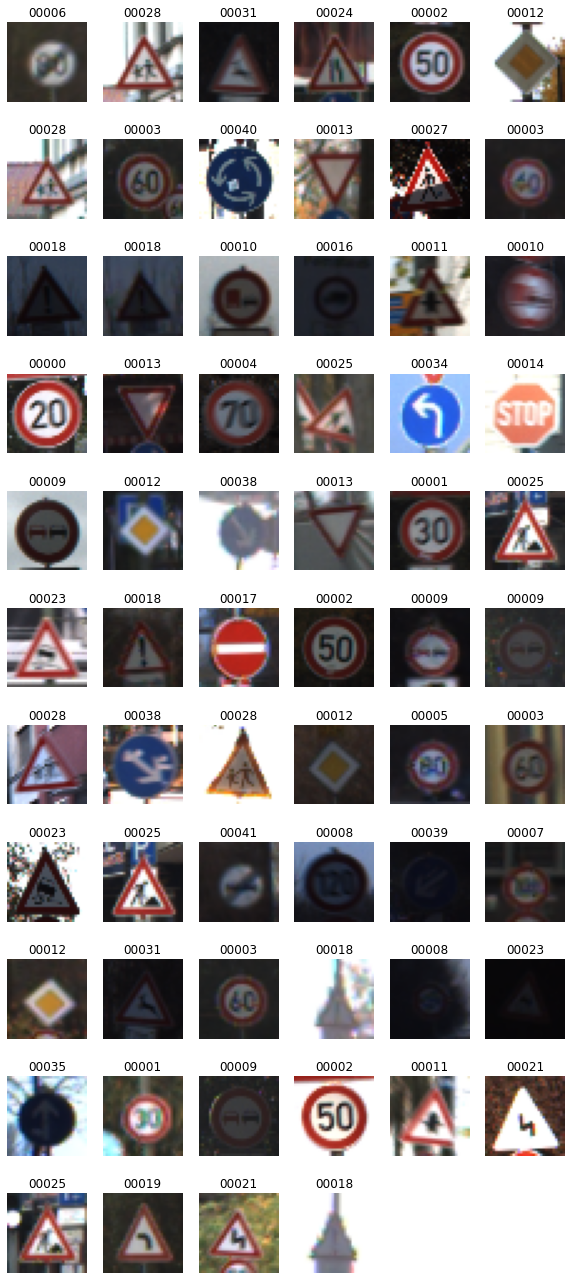

In [19]:
image_batch, label_batch = next(iter(test_Data))        
show_batch(image_batch, label_batch.numpy())

In [20]:

model = Sequential()

model.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
model.add(LeakyReLU(alpha=0.01))  
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(196, (5, 5) )) 
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(256, (5, 5) ) )   
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Flatten())
model.add(LeakyReLU(alpha=0.0)) 
model.add(Dense(384))
model.add(LeakyReLU(alpha=0.0))             
model.add(Dropout(0.5)) 

model.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])


In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 196)       627396    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 196)       0         
                                                        

In [23]:
file_path = './TrainModels/Dynamic_Augmentation.ckpt'

callbacks = prepare_callbacks(file_path)

history = model.fit(train_Data, steps_per_epoch = 0.8 * train_Data_length/BATCH_SIZE,
          epochs=30, 
          validation_data=val_Data,
          validation_steps=0.2*train_Data_length/BATCH_SIZE, 
          callbacks = callbacks)

Epoch 1/30
  1/490 [..............................] - ETA: 12:35 - loss: 5.7745 - accuracy: 0.0156

KeyboardInterrupt: 

# Version II - dynamic data augmentation

In [24]:
import tensorflow_addons as tfa


def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [26]:
dataV2 = dataset
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = train_Data_length)
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.prefetch(buffer_size=10200)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)
#dataV2 = dataV2.repeat()

In [30]:
modelV2 = Sequential()

modelV2.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
modelV2.add(LeakyReLU(alpha=0.01))  
modelV2.add(BatchNormalization())
modelV2.add(Dropout(0.5)) 

modelV2.add(Conv2D(196, (5, 5) )) 
modelV2.add(LeakyReLU(alpha=0.01))
modelV2.add(MaxPooling2D(pool_size=(2, 2)))
modelV2.add(BatchNormalization())
modelV2.add(Dropout(0.5)) 

modelV2.add(Conv2D(256, (5, 5) ) )   
modelV2.add(LeakyReLU(alpha=0.01))
modelV2.add(MaxPooling2D(pool_size=(2, 2)))
modelV2.add(BatchNormalization())
modelV2.add(Dropout(0.5)) 

modelV2.add(Flatten())
modelV2.add(LeakyReLU(alpha=0.0)) 
modelV2.add(Dense(384))
modelV2.add(LeakyReLU(alpha=0.0))             
modelV2.add(Dropout(0.5)) 

modelV2.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

modelV2.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])


In [31]:
file_pathV2 = './TrainModels/Dynamic_Augmentation.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)

historyV2 = modelV2.fit(dataV2, steps_per_epoch = 10200/BATCH_SIZE,
           epochs=50, 
           validation_data = val_Data, 
           callbacks = callbacksV2)
    

Epoch 1/50
  3/159 [..............................] - ETA: 5:04 - loss: 5.2649 - accuracy: 0.0417

KeyboardInterrupt: 

In [ ]:
show_history(historyV2)

modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)
valV2 = modelV2.evaluate(valset, verbose=2)

# Version III - Massive data augmentation

In [32]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [33]:
dataV3 = dataset
# color ops
dataV3 = dataV3.map(process_brightness)
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
dataV3 = dataV3.concatenate(dataset.map(process_crop))

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = 81600)
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)
#dataV3 = dataV3.repeat()


In [34]:
modelV3 = Sequential()

modelV3.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
modelV3.add(LeakyReLU(alpha=0.01))  
modelV3.add(BatchNormalization())
modelV3.add(Dropout(0.5)) 

modelV3.add(Conv2D(196, (5, 5) )) 
modelV3.add(LeakyReLU(alpha=0.01))
modelV3.add(MaxPooling2D(pool_size=(2, 2)))
modelV3.add(BatchNormalization())
modelV3.add(Dropout(0.5)) 

modelV3.add(Conv2D(256, (5, 5) ) )   
modelV3.add(LeakyReLU(alpha=0.01))
modelV3.add(MaxPooling2D(pool_size=(2, 2)))
modelV3.add(BatchNormalization())
modelV3.add(Dropout(0.5)) 

modelV3.add(Flatten())
modelV3.add(LeakyReLU(alpha=0.0)) 
modelV3.add(Dense(384))
modelV3.add(LeakyReLU(alpha=0.0))             
modelV3.add(Dropout(0.5)) 

modelV3.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

modelV3.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])

In [37]:
file_pathV3 = './TrainModels/Dynamic_Augmentation.ckpt'

callbacksV3 = prepare_callbacks(file_pathV3)

# historyV3 = modelV3.fit(dataV3, steps_per_epoch = 81600/BATCH_SIZE,
#           epochs=50, 
#           validation_data = valset, 
#           callbacks = callbacksV3)

historyV3 = modelV3.fit(dataV3,
          epochs=50, 
          validation_data = val_Data, 
          callbacks = callbacksV3)      

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
show_history(historyV3)

modelV3.load_weights(file_pathV3)

evalV3 = modelV3.evaluate(testset, verbose=2)
valV3 = modelV3.evaluate(valset, verbose=2)

In [ ]:


show_accuracies(['V1', 'V2', 'V3'], [evalV1[1], evalV2[1], evalV3[1]], [valV1[1], valV2[1], valV3[1]])

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV3.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((4170 - 4170*.9933)/3 + 1))

In [ ]:
all_labels = [np.argmax(x) for x in numpy_labels]
all_preds = [np.argmax(x) for x in pred]
    
conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

show_confusion_matrix(conf_mat.numpy(), 8)
